# Cusp-capturing PINN - Example 2
> Table 2 - $\phi$

* level set augmentation: $\phi$

### Import packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import functools
from pyDOE import lhs

from functorch import make_functional, vmap, grad, jacrev, hessian

from collections import namedtuple, OrderedDict
import datetime
import time
from IPython.display import clear_output 

import warnings
warnings.filterwarnings('ignore')

### Empty cache and check devices 

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cpu


### Pre-setup

In [3]:
# domain [a,b]\times[c,d]
ba = -1.
bb = 1.
bc = -1.
bd = 1.
dstab = bb - ba
dstcd = bd - bc
# \beta^+, \beta^-, and \eta
btao = 1.
btai = 10.
eta  = btai/btao
bta_jmp = btao - btai
bta_sum = btao + btai
gamma = 1.
alpha = 0.
cfao = alpha/btao
cfai = alpha/btai
# radii of the ellipse
radx = .5
rady = .5
rxsq = radx * radx
rysq = rady * rady
# tolerence for LM
tol_main    = 10**(-10)
tol_machine = 10**(-15)
mu_max      = 10**8
mu_ini      = 10**8
# iteration counts and check
tr_iter_max    = 3000                      # max. iteration
ts_input_new   = 1000                       # renew testing points 
ls_check       = 1000
ls_check0      = ls_check - 1
# number of training points and testing points
N_tsd_final = 250000 #100*N_trd
N_tsg_final = 1000   #10*N_trg

### Exact solution, level set function, and right-hand-side

In [4]:
def levfun(x, y):
    qo = x*x/rxsq + y*y/rysq - 1.0
    q = np.zeros( (len(x),6) )
    q[:,0:1] = qo
    q[:,1:2] = 2.*x/rxsq
    q[:,2:3] = 2.*y/rysq
    q[:,3:4] = 2./rxsq + 2./rysq    
    q[:,4:5] = q[:,1:2] * q[:,1:2] + q[:,2:3] * q[:,2:3]
    q[:,5:6] = alpha/exact_b(x, y, qo)
    return qo, q

def levfun_grad(x, y):  
    qvec = np.hstack( ( 2*x/rxsq , 2*y/rysq ) )
    return qvec


def lvnorvec(x, y):
    qnorvec = np.zeros( (len(x),2) )
    dqx = 2*x/rxsq
    dqy = 2*y/rysq
    dqsqrt = np.sqrt( dqx*dqx + dqy*dqy )
    qnorvec[:,0:1] = dqx/dqsqrt
    qnorvec[:,1:2] = dqy/dqsqrt
    return qnorvec, dqsqrt


# exact solution 
def exact_u(x, y, z):
    eu = np.zeros_like(z)
    dd = x*x/rxsq + y*y/rysq
    for i in range(len(z)):
        if z[i] >= 0.:
            eu[i] = - gamma*np.log( dd[i] )
        else:
            eu[i] = 1. - np.exp( (dd[i]-1.)/eta )
    return eu

def exact_gradu(x, y, z):
    eux = np.zeros_like(z)
    euy = np.zeros_like(z)
    dd = x*x/rxsq + y*y/rysq
    cfxp = -2*gamma/rxsq
    cfyp = -2*gamma/rysq
    cfxn = -2/(rxsq*eta)
    cfyn = -2/(rysq*eta)
    for i in range(len(z)):
        if z[i] >= 0.:
            eux[i] = cfxp*( x[i]/dd[i] )
            euy[i] = cfyp*( y[i]/dd[i] )
        else:
            tp = np.exp( (dd[i]-1.)/eta )
            eux[i] = cfxn*x[i]*tp
            euy[i] = cfyn*y[i]*tp
    return eux, euy

def exact_BCs(x, y, dbc, nbc, n1, n2): 
    # example 01
    dd = x*x/rxsq + y*y/rysq 
    u  = - gamma*np.log( dd )
    ux = (-2*gamma/rxsq)*(x/dd)
    uy = (-2*gamma/rysq)*(y/dd)
    ubc = dbc*u + nbc*( ux*n1 + uy*n2 )
    return ubc


def exact_b(x, y, z):
    eb = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] >= 0.:
            eb[i] = btao
        else:
            eb[i] = btai
    return eb


# normal derivative jump of level set function
def jump_lvdn(x, y):
    # when continuous augmented input used
    qdn_jmp = 2 * np.sqrt( x*x/(rxsq*rxsq) + y*y/(rysq*rysq) )
    return qdn_jmp


# normal derivative jump condition along interface:
def jump_btadun(x, y):
    dun = - 4*(btao*gamma-btai/eta)*np.ones_like(x)
    return dun


# source
def lapu(x, y, z):
    eu = exact_u(x, y, z)
    dd = x*x/rxsq + y*y/rysq
    gdD2 = 4.*( x*x/(rxsq*rxsq) + y*y/(rysq*rysq) )
    lapD = np.ones_like(z) * ( 2./rxsq + 2./rysq )
    ef = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] >= 0.:
            ef[i] = ( gdD2[i]/dd[i] - lapD[i] )/dd[i] - cfao*eu[i]
        else:
            ef[i] = - np.exp((dd[i]-1.)/eta)*( lapD[i] + gdD2[i]/eta )/eta - cfai*eu[i]            
    return ef

### Define networks: Shallow and Deep

In [5]:
class NeuralNet_Shallow(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    
    def __init__(self, in_dim , h_dim , out_dim):
        super(NeuralNet_Shallow, self).__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        #self.act1 = nn.Tanh()
        #self.act1 = nn.ReLU()
        
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out

In [6]:
class NeuralNet_Deep(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim , h_dim , out_dim , depth ):
        super(NeuralNet_Deep, self).__init__()
        self.depth = depth - 1
        self.list  = nn.ModuleList()
        self.ln1   = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        #self.act1 = nn.Tanh()
        #self.act1 = nn.ReLU()
        
        for i in range(self.depth):
            self.list.append( nn.Linear( h_dim , h_dim ) )
        
        self.lnd = nn.Linear( h_dim , out_dim, bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        for i in range(self.depth):
            out = self.list[i](out)
            out = self.act1(out)
        out = self.lnd(out)
        return out

### Essential namedtuples in the model

In [7]:
DataInput = namedtuple( "DataInput" , [ "Xd" , "Fd" , "Xb" , "Fb" , "Xg" , "Fg" , "NL" , "NL_sqrt"] )
LM_Setup  = namedtuple( "LM_Setup" , [ 'p_vec_o' , 'dp_o' , 'L_o' , 'J_o' , 'mu0' , 'criterion' ] )

### Data generator

In [8]:
def generate_data(iopt, Nd, Nb, Ng):
    
    ## Xd: points inside the domain (randomly)
    sampling = lhs(2, Nd)
    xd = ba + dstab*sampling[:,0:1]
    yd = bc + dstcd*sampling[:,1:2]
    qdo, qd = levfun(xd, yd)
    # remove points at the interface
    qid = np.where(np.abs(qdo)<5e-16)
    qd  = np.delete(qd, qid[0], 0)
    xd  = np.delete(xd, qid[0], 0)
    yd  = np.delete(yd, qid[0], 0)
    qdo = np.delete(qdo, qid[0], 0)    
    # torch tensor and requires_grad
    Xd = np.hstack( ( xd , yd , qd[:,0:1] ) )  
    # right hand side
    fd = lapu(xd, yd, qdo)
    Fd = np.hstack( ( fd , qd[:,1:] ) )
    Nd_new = len(fd)

    ## Xb: points at the boundary
    xb = ba + dstab*lhs(1, Nb)
    yb = bc + dstcd*lhs(1, Nb)
    tpx = np.ones_like(xb)
    tpy = np.ones_like(yb)
    sbx = np.vstack( ( ba*tpy , bb*tpy , xb     , xb     ) )
    sby = np.vstack( ( yb     , yb     , bc*tpx , bd*tpx ) )
    pgd = levfun_grad(sbx, sby)
    qbo, qb = levfun(sbx , sby)
    bn1 = np.vstack( ( -tpy , tpy , np.zeros((Nb,1)) , np.zeros((Nb,1)) ) )
    bn2 = np.vstack( ( np.zeros((Nb,1)) , np.zeros((Nb,1)) , -tpx , tpx ) )
    Dbc = np.vstack( ( tpy , tpy , np.zeros((Nb,1)) , np.zeros((Nb,1)) ) )
    Nbc = np.vstack( ( np.zeros((Nb,1)) , np.zeros((Nb,1)) , tpx , tpx ) )
    # Boundary condition
    fb = exact_BCs(sbx, sby, Dbc, Nbc, bn1, bn2)
    Nb_new = len(fb)
    # combine
    Xb = np.hstack( ( sbx , sby , qb[:,0:1] ) )
    Fb = np.hstack( ( fb , bn1 , bn2 , pgd , Dbc , Nbc ) )
       
    ## X_gma: points on the interface N_trg
    #np.random.seed(1234)
    thet = 2*np.pi*( lhs(1, Ng) + lhs(1,1) )
    xg = 0.5*(ba+bb) + radx * np.cos(thet)
    yg = 0.5*(bc+bd) + rady * np.sin(thet)
    qg = np.zeros_like(xg)
    Xg = np.hstack( ( xg , yg , qg ) )
    # normal vector along the interface
    norvec, dqnorm = lvnorvec(xg, yg)
    # normal derivative jump condition for u
    flux_jp = jump_btadun(xg, yg)     
    # combine and torch tensor
    Fg = np.hstack( ( flux_jp, norvec , bta_jmp*np.ones_like(flux_jp) , bta_jmp*dqnorm ) ) 
    
    NL      = [Nd_new+Nb_new+Ng, Nd_new, Nb_new, Ng]
    NL_sqrt = np.sqrt(NL)
    
    ## plot the distribution of data
    if iopt != 0:
        print(f'No. of training points in the bulk domain: {Nd_new}')
        print(f'No. of training points at the outer boundary: {Nb_new}')
        print(f'No. of training points at the interface: {Ng}')
        
    Xd = torch.tensor(Xd, requires_grad=True).double().to(device)
    Fd = torch.tensor(Fd).double().to(device)
    Xb = torch.tensor(Xb, requires_grad=True).double().to(device)
    Fb = torch.tensor(Fb).double().to(device)
    Xg = torch.tensor(Xg, requires_grad=True).double().to(device)
    Fg = torch.tensor(Fg).double().to(device)
    
    return Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt 

### Components of loss

In [9]:
# compute the interior loss
def func_lossd(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u wrt inputs
    
    d1u = jacrev(f)(pts, func_params)
    d2u = jacrev(jacrev(f))(pts, func_params)
    
    u    = f(pts, func_params)
    u_z  = d1u[2]
    u_xz = d2u[0][2] 
    u_xx = d2u[0][0]
    u_yz = d2u[1][2] 
    u_yy = d2u[1][1]
    u_zz = d2u[2][2]
    lossd = u_xx + u_yy + 2.*( u_xz*fd[1] + u_yz*fd[2] ) + u_z*fd[3] + u_zz*fd[4] - u*fd[5] - fd[0]
    return lossd #/pnt_fd


# compute the boundary loss 
def func_lossb(func_params, pts, fb):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # function value at the boundary (Dirichlet)
    u = f(pts, func_params)
    # function value at the boundary (Neumann)
    d1u = jacrev(f)(pts, func_params)
    
    ux = d1u[0]
    uy = d1u[1]
    uz = d1u[2]
    # loss (a*w + b*dwn = c)
    lossb = fb[5]*u + fb[6]*( (ux+uz*fb[3])*fb[1] + (uy+uz*fb[4])*fb[2] ) - fb[0]
    return lossb


# compute the interfacial loss
def func_lossg(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u wrt inputs
    d1u = jacrev(f)(pts, func_params)
    ux = d1u[0]
    uy = d1u[1]
    uz = d1u[2]
    lossg = fg[3]*(ux*fg[1]+uy*fg[2]) + uz*fg[4] - fg[0]
    return lossg

def func_pred_gradu(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # gradu
    d1u = jacrev(f)(pts, func_params)
    ux = d1u[0]
    uy = d1u[1]
    uz = d1u[2]
    dux = ux + uz*fd[0]
    duy = uy + uz*fd[1]
    return dux, duy


### Levenberg-Marquardt (LM) optimizer

In [10]:
# parameters counter
def count_parameters(func_params):
    return sum(p.numel() for p in func_params if p.requires_grad)

In [11]:
# get the model's parameter
def get_p_vec(func_params):
    p_vec = []
    cnt = 0
    for p in func_params:
        p_vec = p.contiguous().view(-1) if cnt == 0 else torch.cat([p_vec, p.contiguous().view(-1)])
        cnt = 1 
    return p_vec

In [12]:
# Initialization of LM method
def generate_initial_LM(func_params, Xd_len, Xb_len, Xg_len):
    
    # data_length
    data_length = Xd_len + Xb_len + Xg_len
    
    # p_vector
    with torch.no_grad():
        p_vec_old = get_p_vec(func_params).double().to(device)
    
    # dp
    dp_old = torch.zeros( [ count_parameters(func_params) , 1 ] ).double().to(device)

    # Loss
    L_old = torch.zeros( [ data_length , 1 ] ).double().to(device)
    
    # Jacobian
    J_old = torch.zeros( [ data_length , count_parameters(func_params) ] ).double().to(device)
    
    return p_vec_old, dp_old, L_old, J_old

In [13]:
def train_PINNs_LM(func_params, LM_setup, tr_input, lossval, lossval_dbg):
    
    # assign tuple elements of LM_set_up
    p_vec_o, dp_o, L_o, J_o, mu, criterion = LM_setup
    I_pvec = torch.eye(len(p_vec_o)).to(device)
    
    # assign tuple elements of data_input 
    [Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt] = tr_input
    
    # iteration counts and check
    Comput_old = True
    step       = 0
    
    # try-except statement to avoid jam in the code
    try:
        while (lossval[-1]>tol_main) and (step<=tr_iter_max):
            
            torch.cuda.empty_cache()
            
            ############################################################
            # LM_optimizer
            if ( Comput_old == True ):   # need to compute loss_old and J_old
                
                ### computation of loss
                Ld = vmap((func_lossd), (None, 0, 0))(func_params, Xd, Fd).flatten().detach()
                Lb = vmap((func_lossb), (None, 0, 0))(func_params, Xb, Fb).flatten().detach()
                Lg = vmap((func_lossg), (None, 0, 0))(func_params, Xg, Fg).flatten().detach()
                L  = torch.cat( ( Ld/NL_sqrt[1] , Lb/NL_sqrt[2] , Lg/NL_sqrt[3] ) )
                L  = L.reshape(NL[0],1).detach()
                lsd_sum = torch.sum(Ld*Ld)/NL[1]
                lsb_sum = torch.sum(Lb*Lb)/NL[2]
                lsg_sum = torch.sum(Lg*Lg)/NL[3]
                loss_dbg_old = [lsd_sum.item(), lsb_sum.item(), lsg_sum.item()]
                        
            loss_old     = lossval[-1]
            loss_dbg_old = lossval_dbg[-1]
    
            ### compute the gradinet of loss function for each point
            with torch.no_grad():
                p_vec = get_p_vec(func_params).detach() # get p_vec for p_vec_old if neccessary 
        
            if criterion:
                per_sample_grads = vmap(jacrev(func_lossd), (None, 0, 0))(func_params, Xd, Fd)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1

                per_sample_grads = vmap(jacrev(func_lossb), (None, 0, 0))(func_params, Xb, Fb)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_b,g.reshape(len(g),-1)])
                    cnt = 1
        
                per_sample_grads = vmap(jacrev(func_lossg), (None, 0, 0))(func_params, Xg, Fg)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_g,g.reshape(len(g),-1)])
                    cnt = 1
            
                J = torch.cat( ( J_d/NL_sqrt[1] , J_b/NL_sqrt[2] , J_g/NL_sqrt[3] ) ).detach()
                
                ### info. normal equation of J
                J_product = J.t()@J
                rhs       = - J.t()@L
                    
            with torch.no_grad():
                ### solve the linear system
                dp  = torch.linalg.solve( J_product + mu*I_pvec , rhs )
                cnt = 0
                for p in func_params:
                    mm   = torch.Tensor([p.shape]).tolist()[0]
                    num  = int( functools.reduce( lambda x,y : x*y, mm, 1 ) )
                    p   += dp[cnt:cnt+num].reshape(p.shape)
                    cnt += num
            
            # start the timer
            cnt_start1 = time.time()
            
            ### Compute loss_new    
            Ld = vmap((func_lossd), (None, 0, 0))(func_params, Xd, Fd).flatten().detach()
            Lb = vmap((func_lossb), (None, 0, 0))(func_params, Xb, Fb).flatten().detach()
            Lg = vmap((func_lossg), (None, 0, 0))(func_params, Xg, Fg).flatten().detach()
            L  = torch.cat( ( Ld/NL_sqrt[1] , Lb/NL_sqrt[2] , Lg/NL_sqrt[3] ) )
            L  = L.reshape( NL[0] , 1 ).detach()
            loss_new = torch.sum(L*L).item()
            lsd_sum = torch.sum(Ld*Ld)/NL[1]
            lsb_sum = torch.sum(Lb*Lb)/NL[2]
            lsg_sum = torch.sum(Lg*Lg)/NL[3]
            loss_dbg_new = [lsd_sum.item(), lsb_sum.item(), lsg_sum.item()]
            
            # strategy to update mu
            if ( step > 0 ):
                
                with torch.no_grad():
             
                    # accept update 
                    if loss_new < loss_old:
                        p_vec_old  = p_vec.detach()
                        dp_old     = dp
                        L_old      = L
                        J_old      = J
                        mu         = max( mu/mu_div , tol_machine )
                        criterion  = True #False
                        Comput_old = False
                        lossval.append(loss_new)
                        lossval_dbg.append(loss_dbg_new)
                    
                    else:
                        cosine = nn.functional.cosine_similarity(dp, dp_old, dim=0, eps=1e-15)
                        cosine_check = (1.-cosine)*loss_new > min(lossval) # loss_old
                        if cosine_check: # give up the direction
                            cnt=0
                            for p in func_params:
                                mm   = torch.Tensor([p.shape]).tolist()[0]
                                num  = int( functools.reduce(lambda x,y: x*y, mm, 1) )
                                p   -= dp[cnt:cnt+num].reshape(p.shape)
                                cnt += num
                            mu = min( mu_mul*mu , mu_max )
                            criterion  = False
                            Comput_old = False
                        else: # accept 
                            p_vec_old = p_vec.detach()
                            dp_old    = dp 
                            L_old     = L
                            J_old     = J
                            mu        = max( mu/mu_div , tol_machine )       
                            criterion  = True
                            Comput_old = False
                        lossval.append(loss_old)
                        lossval_dbg.append(loss_dbg_old)
            
            else:   # for old info. 
       
                with torch.no_grad():
              
                    p_vec_old  = p_vec.detach()
                    dp_old     = dp
                    L_old      = L
                    J_old      = J
                    mu         = max( mu/mu_div , tol_machine )
                    criterion  = True
                    Comput_old = False
                    lossval.append(loss_new)
                    lossval_dbg.append(loss_dbg_new)
            
           
            if step % ls_check == ls_check0:
                print("Step %s: " % (step) )
                print(f" training loss: {lossval[-1]:.4e}")
                        
            step += 1
                  
        print("Step %s: " % (step-1) )
        print(f" training loss: {lossval[-1]:.4e}")
        print('finished')
        lossval     = lossval[1:]
        lossval_dbg = lossval_dbg[1:]
        relerr_loss = lossval[-1]
        return lossval, lossval_dbg, relerr_loss
    
    except KeyboardInterrupt:
        print('Interrupt')
        print('steps = ', step)
        lossval     = lossval[1:]
        lossval_dbg = lossval_dbg[1:]
        relerr_loss = lossval[-1]
        return lossval, lossval_dbg, relerr_loss

In [14]:
# create names for storages
fname = 'test'
char_id = 'a'

# Network size
n_input  = 3
n_hidden = 40
n_output = 1
n_depth = 1 # only used in deep NN
mu_div = 3.
mu_mul = 2.

# number of training and test data points
c_addpt = 1.
M0 = 30
N_trd = M0*M0
N_trb = M0
N_trg = 3*M0

# storages for errors, time instants, and IRK stages
relerr_loss = []
for char in char_id:
    
    # file name
    fname_char = fname+char 

    torch.cuda.empty_cache()
    
    # NN structure
    if n_depth == 1:   # Shallow NN
        model = NeuralNet_Shallow( n_input , n_hidden , n_output ).double().to(device)
    else:   # Deep NN
        model = NeuralNet_Deep( n_input , n_hidden , n_output , n_depth ).double().to(device)

    # use Pytorch and functorch
    func_model, func_params = make_functional(model)
    
    # generate training data
    Xd_tr, Fd_tr, Xb_tr, Fb_tr, Xg_tr, Fg_tr, NL_tr, NL_sqrt_tr = generate_data(1, N_trd, N_trb, N_trg)
    tr_input = DataInput(Xd=Xd_tr, Fd=Fd_tr, Xb=Xb_tr, Fb=Fb_tr, Xg=Xg_tr, Fg=Fg_tr, NL=NL_tr, NL_sqrt=NL_sqrt_tr)
        
    # initialization of LM
    p_vec_old, dp_old, L_old, J_old = generate_initial_LM(func_params, NL_tr[1], NL_tr[2], NL_tr[3])
    print(f"No. of parameters = {len(p_vec_old)}")
    
    # LM_setup
    mu = 10**(8)
    criterion = True
    LM_setup = LM_Setup( p_vec_o=p_vec_old , dp_o=dp_old , L_o=L_old , J_o=J_old , mu0=mu , criterion=criterion )

    # allocate loss
    lossval         = []
    lossval_dbg     = []
    lossval.append(1.)
    lossval_dbg.append([1.,1.,1.])

    # start the timer
    cnt_start = time.time()

    # train the model by LM optimizer
    lossval, lossval_dbg, relerr_loss_char = train_PINNs_LM(func_params, LM_setup, tr_input, lossval, lossval_dbg)
    relerr_loss.append(relerr_loss_char)

    end_start = time.time()
    total_T = str(datetime.timedelta(seconds=end_start-cnt_start))
    print(f"total time : {total_T}")


No. of training points in the bulk domain: 900
No. of training points at the outer boundary: 120
No. of training points at the interface: 90
No. of parameters = 200
Step 999: 
 training loss: 1.1613e+00
Step 1999: 
 training loss: 1.1613e+00
Step 2999: 
 training loss: 1.1613e+00
Step 3000: 
 training loss: 1.1613e+00
finished
total time : 0:00:19.672516


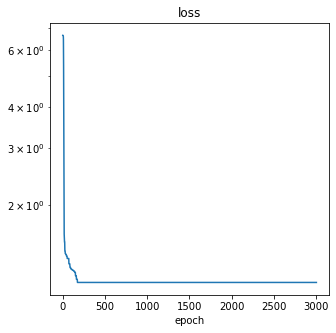

In [15]:
# plot evolution of loss
N_loss = len(lossval)
lossval        = np.array(lossval).reshape(N_loss,1)
epochcol = np.linspace(1, N_loss, N_loss).reshape(N_loss,1)

plt.figure(figsize = (5,5))

plt.semilogy(epochcol, lossval)
plt.title('loss')
plt.xlabel('epoch')
plt.show()

### Testing data

In [16]:
# No. of testing points
print(f'No. of testing point: N_tsin ({N_tsd_final}) ')

# fixed pseudo random generator
#np.random.seed(777)

# testing points
sampling = lhs(2, N_tsd_final)
x = ba + dstab*sampling[:,0:1]
y = bc + dstcd*sampling[:,1:2]
qo, q = levfun(x, y)
X_tsd = np.hstack( ( x , y , q[:,0:1]) )
X_tsd_torch = torch.tensor(X_tsd).double().to(device)
Fd_tsd_torch = torch.tensor(q[:,1:]).double().to(device)

# exact solution of u
ref_u_tsd = exact_u(x, y, qo)
ref_u_tsd_infnorm = np.linalg.norm(ref_u_tsd, np.inf) 
ref_u_tsd_L2norm  = np.linalg.norm(ref_u_tsd, 2)

# exact solution of gradu
ref_dux_tsd, ref_duy_tsd = exact_gradu(x, y, qo)
ref_dux_tsd_infnorm = np.linalg.norm(ref_dux_tsd, np.inf)
ref_duy_tsd_infnorm = np.linalg.norm(ref_duy_tsd, np.inf)
ref_dux_tsd_L2norm  = np.linalg.norm(ref_dux_tsd, 2)
ref_duy_tsd_L2norm  = np.linalg.norm(ref_duy_tsd, 2)

No. of testing point: N_tsin (250000) 


In [17]:
pred_u = func_model(func_params, X_tsd_torch).cpu().detach().numpy().flatten()
abserr = np.abs( pred_u - ref_u_tsd.flatten() )
err_inf = np.linalg.norm(abserr, np.inf)
err_L2  = np.linalg.norm(abserr, 2)
relerr_inf = err_inf / ref_u_tsd_infnorm
print(f"L_inf err.    : {err_inf:.4e}")
print(f"L_inf relerr. : {relerr_inf:.4e}")
relerr_L2  = err_L2 / ref_u_tsd_L2norm
print(f"L_2 err.    : {err_L2:.4e}")
print(f"L_2 relerr. : {relerr_L2:.4e}")
pred_dux, pred_duy = vmap((func_pred_gradu), (None, 0, 0))(func_params, X_tsd_torch, Fd_tsd_torch)
pred_dux = pred_dux.detach().cpu().numpy().flatten()
pred_duy = pred_duy.detach().cpu().numpy().flatten()
abserr_dux = np.abs( pred_dux - ref_dux_tsd.flatten() )
relerr_dux_inf = np.linalg.norm(abserr_dux, np.inf) / ref_dux_tsd_infnorm
print(f"L_inf relerr_dux. : {relerr_dux_inf:.4e}")
relerr_dux_L2  = np.linalg.norm(abserr_dux, 2) / ref_dux_tsd_L2norm
print(f"L_2   relerr_dux. : {relerr_dux_L2:.4e}")
abserr_duy = np.abs( pred_duy - ref_duy_tsd.flatten() )
relerr_duy_inf = np.linalg.norm(abserr_duy, np.inf) / ref_duy_tsd_infnorm
print(f"L_inf relerr_duy. : {relerr_duy_inf:.4e}")
relerr_duy_L2  = np.linalg.norm(abserr_duy, 2) / ref_duy_tsd_L2norm
print(f"L_2   relerr_duy. : {relerr_duy_L2:.4e}")        

L_inf err.    : 1.8861e+00
L_inf relerr. : 9.0873e-01
L_2 err.    : 5.6984e+02
L_2 relerr. : 1.0983e+00
L_inf relerr_dux. : 1.0006e+00
L_2   relerr_dux. : 1.1048e+00
L_inf relerr_duy. : 9.8617e-01
L_2   relerr_duy. : 9.0939e-01


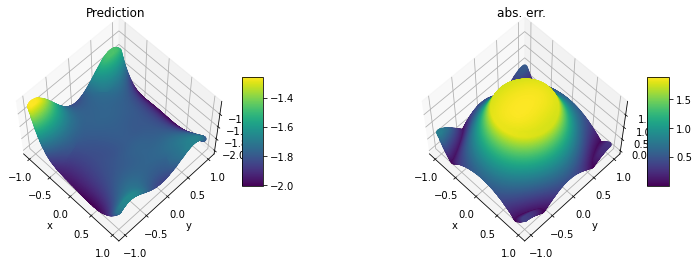

In [18]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.scatter(X_tsd[:,0:1], X_tsd[:,1:2], pred_u, c=pred_u)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction')
ax.view_init(elev=60, azim=-45)

# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.scatter(X_tsd[:,0:1], X_tsd[:,1:2], abserr, c=abserr)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('abs. err.')
ax.view_init(elev=60, azim=-45)
plt.show()